# 📦 Index Benchmarking on JSONB in PostgreSQL  
### GIN vs BTREE vs HASH — Full Guide with Benchmarks

PostgreSQL’s **JSONB** type is one of its most powerful features — letting you store flexible,
schema-free data while still enabling fast indexing and search.

But JSONB becomes slow **very quickly** as your dataset grows…  
unless you index it correctly.

In this tutorial, we will:

- Generate **5,000,000 synthetic JSONB rows**
- Benchmark queries **with and without indexes**
- Run **timings** using SQL + Python inside Jupyter
- Compare **GIN**, **BTREE**, , and **HASH** indexes
- Understand **when each index is useful**


By the end, you’ll know exactly **which index type** to use for your JSONB workloads.

Let's dive in 🚀


## 1. Setup (Python + PostgreSQL Connection)

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
import psycopg2
import psycopg2.extras
import pandas as pd
import time

import json
import random

import matplotlib.pyplot as plt

%matplotlib inline

# Load .env if present
print("Environment Variables Loaded? ", load_dotenv())

DB_CONFIG = {
    "host": os.getenv("PG_HOST", "localhost"),
    "port": os.getenv("PG_PORT", "5432"),
    "dbname": os.getenv("PG_DATABASE", "postgres"),
    "user": os.getenv("PG_USER", "postgres"),
    "password": os.getenv("PG_PASS", "postgres"),
}

Environment Variables Loaded?  True


In [3]:
def get_connection(autocommit=True):
    connection = psycopg2.connect(**DB_CONFIG)
    connection.autocommit=autocommit
    cursor = connection.cursor()

    return connection, cursor
    
# Quick connection test
try:
    connection, cursor = get_connection()
    print("Connected to PostgreSQL")
except Exception as e:
    print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

Connected to PostgreSQL


## 2. Create Table for Benchmarking 

In [4]:
try:
    connection, cursor = get_connection()
    
    cursor.execute("""
    DROP TABLE IF EXISTS jsonb_benchmark;
    CREATE TABLE jsonb_benchmark (
        id SERIAL PRIMARY KEY,
        payload JSONB
    );
    """)

    print("jsonb_benchmark table created successfully...")
except Exception as e:
    print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

jsonb_benchmark table created successfully...


## 3. Generate 5,000,000 Synthetic JSONB Rows

In [5]:
import random

import faker
fake = faker.Faker()

def generate_row():
    return {
        "user": {
            "id": fake.random_int(1, 5000),
            "name": fake.name(),
            "country": fake.country(),
        },
        "activity": {
            "type": random.choice(["search", "click", "purchase", "view"]),
            "duration_ms": random.randint(20, 5000),
            "success": random.choice([True, False])
        },
        "tags": random.sample(
            ["ai", "ml", "python", "postgres", "database", "json", "api", "cloud"],
            k=random.randint(2, 5)
        )
    }

In [6]:
%%time

rows = [generate_row() for i in range(5_000_000)]

rows[0]

CPU times: user 3min 53s, sys: 1.14 s, total: 3min 55s
Wall time: 3min 55s


{'user': {'id': 4127, 'name': 'Misty Miller', 'country': 'Bangladesh'},
 'activity': {'type': 'click', 'duration_ms': 4086, 'success': False},
 'tags': ['api', 'ml']}

## 4. Insert Data into Table

In [7]:
%%time

try:
    connection, cursor = get_connection()

    psycopg2.extras.execute_values(
        cursor,
        "INSERT INTO jsonb_benchmark (payload) VALUES %s",
        [(psycopg2.extras.Json(row),) for row in rows]
    )

    cursor.execute("SELECT COUNT(*) FROM jsonb_benchmark;")
    cnt = cursor.fetchone()[0]

    print(f"Inserted {cnt:,} into jsonb_benchmark table successfully...\n")
except Exception as e:
    print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

Inserted 5,000,000 into jsonb_benchmark table successfully...

CPU times: user 1min 23s, sys: 3.33 s, total: 1min 26s
Wall time: 3min 2s


## 5. Benchmark Helper Functions

In [8]:
def run_query(sql, repeats=5):
    try:
        connection, cursor = get_connection()
    
        times = []
        for _ in range(repeats):
            start = time.time()
            cursor.execute(sql)
            cursor.fetchall()
            times.append((time.time() - start)*1000) ## Multiplying by 1000 to convert seconds to ms
        
        return min(times)
    except Exception as e:
        print("Connection failed:", e)
    finally:
        cursor.close()
        connection.close()

## 6. Baseline Query Performance (No Index)

In [9]:
try:
    connection, cursor = get_connection()

    query_country = """
    SELECT * FROM jsonb_benchmark
    WHERE payload @> '{"user": {"country": "Netherlands"}}';
    """
    
    no_index_time = run_query(query_country)
    print(f"Query Execution Time: {no_index_time:.3f} ms")
except Exception as e:
        print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

Query Execution Time: 259.356 ms


In [10]:
try:
    connection, cursor = get_connection()

    query_country = """
    EXPLAIN ANALYZE
    SELECT * FROM jsonb_benchmark
    WHERE payload @> '{"user": {"country": "Netherlands"}}';
    """
    
    cursor.execute(query_country)
    rows = [row[0] for row in cursor.fetchall()]
    print("\n".join(rows))
except Exception as e:
        print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

Gather  (cost=1000.00..188828.11 rows=500 width=230) (actual time=0.818..215.659 rows=20630.00 loops=1)
  Workers Planned: 2
  Workers Launched: 2
  Buffers: shared hit=15974 read=145759 written=190
  ->  Parallel Seq Scan on jsonb_benchmark  (cost=0.00..187778.11 rows=208 width=230) (actual time=0.582..209.865 rows=6876.67 loops=3)
        Filter: (payload @> '{"user": {"country": "Netherlands"}}'::jsonb)
        Rows Removed by Filter: 1659790
        Buffers: shared hit=15974 read=145759 written=190
Planning:
  Buffers: shared hit=80
Planning Time: 1.027 ms
Execution Time: 216.208 ms


### 📝 Baseline Result
This shows how slow a JSONB search is **without any indexes**.

Expect 100–500 ms on 5 Mn rows depending on your machine.

Next, we’ll see how indexes dramatically change performance.


## 7. Create GIN Index (The Most Important One)

#### What it is

GIN is the most common index for JSONB in PostgreSQL.
It indexes every key/value pair inside a JSONB document, making lookups extremely fast.

#### What it’s good for

* Existence checks**
    ```sql
    WHERE payload ? 'user'
    WHERE payload ?| array['user', 'email']
    ```
* **Contains queries**
    ```sql
    WHERE payload @> '{"category": "AI"}'
    ```
* **Deep key/value matching**
    ```sql
    WHERE payload->'user'->>'country' = 'Netherlands'
    ```

#### When to use

* When documents are large and deeply nested
* When you frequently filter on multiple JSON keys
* When your queries include `@>`, `?`, `?|`, `?&`, existence operators
* When you need fast search across thousands/millions of JSON objects

#### When NOT to use

* When you have small JSON documents (overkill)
* When writes are very frequent — GIN slows down inserts/updates
* When queries mainly filter on a single known path (use BTREE or JSON path index instead)

#### Pros

* Extremely fast reads
* Great for "contains" queries
* Indexes full JSON structure
* Flexible: supports most JSON operators

#### Cons

* Slower writes
* Index size can be large
* Not ideal for numeric range queries

In [11]:
try:
    connection, cursor = get_connection()

    cursor.execute("""
    CREATE INDEX IF NOT EXISTS jsonb_gin_idx
    ON jsonb_benchmark 
    USING GIN (payload jsonb_path_ops);""")
except Exception as e:
    print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

1. `Normal GIN`: indexes all key/value pairs
2. `jsonb_path_ops`: indexes only keys and their hierarchical path representation
    * Faster & smaller index when using `@>` operator. Only supports containment operator (`@`).
    * GREAT for containment queries
    * If you don't need support for `?`, `?|`, etc.
    * If index size is a concern

### Benchmark Query with GIN


In [17]:
try:
    connection, cursor = get_connection()

    query_country = """
    SELECT * FROM jsonb_benchmark
    WHERE payload @> '{"user": {"country": "Netherlands"}}';
    """
    
    gin_time = run_query(query_country)
    print(f"Query Execution Time (GIN Index): {gin_time:.3f} ms")
except Exception as e:
        print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

Query Execution Time (GIN Index): 71.403 ms


In [18]:
try:
    connection, cursor = get_connection()

    query_country = """
    EXPLAIN ANALYZE
    SELECT * FROM jsonb_benchmark
    WHERE payload @> '{"user": {"country": "Netherlands"}}';
    """
    
    cursor.execute(query_country)
    rows = [row[0] for row in cursor.fetchall()]
    print("\n".join(rows))
except Exception as e:
        print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

Bitmap Heap Scan on jsonb_benchmark  (cost=23.98..1946.83 rows=500 width=230) (actual time=7.853..55.335 rows=20630.00 loops=1)
  Recheck Cond: (payload @> '{"user": {"country": "Netherlands"}}'::jsonb)
  Heap Blocks: exact=19402
  Buffers: shared hit=1 read=19413
  ->  Bitmap Index Scan on jsonb_gin_idx  (cost=0.00..23.85 rows=500 width=0) (actual time=5.591..5.592 rows=20630.00 loops=1)
        Index Cond: (payload @> '{"user": {"country": "Netherlands"}}'::jsonb)
        Index Searches: 1
        Buffers: shared hit=1 read=11
Planning:
  Buffers: shared hit=80 read=25
Planning Time: 1.744 ms
Execution Time: 56.068 ms


### 🔥 GIN Performance Boost
GIN is *by far* the fastest index type for JSONB search —  
often 10×–50× faster depending on dataset size.

GIN builds a full inverted index over JSONB keys and values, making it ideal for:
- **Key lookup**
- **Path lookup**
- **Containment queries**  
- **Existence checks**


## 8. BTREE Index Benchmark

#### What it is

BTREE does not index JSONB directly — instead, you use it on a computed JSON value, like:

```sql
CREATE INDEX idx_price ON jsonb_benchmark ((payload->'user'->>'country'));
```

#### What it’s good for

* **Sorting**
    ```sql
    ORDER BY (data->>'timestamp')::timestamptz
    ```
* **Equality checks**
  ```sql
  WHERE payload->'user'->>'country' = 'Netherlands'
  ```
* **Indexing frequently-used single fields**

#### When to use

* When you always filter on one specific key
* When that key stores values like:
    * numbers
    * strings
    * timestamps
* When you need fast ORDER BY on a JSONB field

#### When NOT to use

* When queries involve multiple fields
* When you need **containment search (@>)**
* When filtering nested JSON structures

#### Pros

* Very fast for equality & sorting
* Much smaller index size
* Fast writes (lighter than GIN)

#### Cons

* Only indexes one expression (not whole JSON)
* Not suitable for deep/complex JSON queries
* No benefit for `@>`, `?`, path queries

In [19]:
try:
    connection, cursor = get_connection()

    cursor.execute("""
    CREATE INDEX IF NOT EXISTS jsonb_btree_country
    ON jsonb_benchmark ((payload->'user'->>'country'));
    """)
except Exception as e:
    print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

In [20]:
try:
    connection, cursor = get_connection()

    query_country = """
    SELECT * FROM jsonb_benchmark
    WHERE payload->'user'->>'country' = 'Netherlands';
    """
    
    btree_time = run_query(query_country)
    print(f"Query Execution Time (BTREE Index): {btree_time:.3f} ms")
except Exception as e:
        print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

Query Execution Time (BTREE Index): 67.206 ms


In [21]:
try:
    connection, cursor = get_connection()

    query_country = """
    EXPLAIN ANALYZE
    SELECT * FROM jsonb_benchmark
    WHERE payload->'user'->>'country' = 'Netherlands';
    """
    
    cursor.execute(query_country)
    rows = [row[0] for row in cursor.fetchall()]
    print("\n".join(rows))
except Exception as e:
        print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

Bitmap Heap Scan on jsonb_benchmark  (cost=282.18..67175.23 rows=25000 width=230) (actual time=7.494..53.651 rows=20630.00 loops=1)
  Recheck Cond: (((payload -> 'user'::text) ->> 'country'::text) = 'Netherlands'::text)
  Heap Blocks: exact=19402
  Buffers: shared read=19423
  ->  Bitmap Index Scan on jsonb_btree_country  (cost=0.00..275.93 rows=25000 width=0) (actual time=3.831..3.831 rows=20630.00 loops=1)
        Index Cond: (((payload -> 'user'::text) ->> 'country'::text) = 'Netherlands'::text)
        Index Searches: 1
        Buffers: shared read=21
Planning:
  Buffers: shared hit=95 read=30
Planning Time: 1.817 ms
Execution Time: 54.438 ms


### 🧐 BTREE Summary
BTREE does **not** index JSONB — only extracted values.  
It’s good only when queries repeatedly filter on a *specific path*.

**Pros:** very fast for equality  
**Cons:** only works on one field  


## 9. HASH Index Benchmark

#### What it is

A simpler index used for equality only. You can index a JSONB field or an expression:
```sql
CREATE INDEX idx_price ON jsonb_benchmark ((payload->'user'->>'country'));
```

#### What it’s good for

* Very simple equality checks
* When BTREE is not ideal (rare)

#### When to use

* You frequently check equality on large text fields
* Your JSON values have no ordering or ranges
* You want a slightly smaller index than BTREE

#### When NOT to use

* You need ordering
* You need contains queries or JSON operators
* You want multi-key search
* You care about crash safety (older versions had issues)

#### Pros

* Simple, lightweight
* Fast equality matching

#### Cons

* Limited (equality only)
* Usually not better than BTREE in practice
* Less common in production

#### Drop BTREE Index First

In [22]:
try:
    connection, cursor = get_connection()

    cursor.execute("""
    DROP INDEX IF EXISTS jsonb_btree_country;
    """)
except Exception as e:
    print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

In [23]:
try:
    connection, cursor = get_connection()

    cursor.execute("""
    CREATE INDEX IF NOT EXISTS jsonb_hash_country
    ON jsonb_benchmark USING HASH ((payload->'user'->>'country'));
    """)
except Exception as e:
    print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

In [24]:
try:
    connection, cursor = get_connection()

    query_country = """
    SELECT * FROM jsonb_benchmark
    WHERE payload->'user'->>'country' = 'Netherlands';
    """
    
    hash_time = run_query(query_country)
    print(f"Query Execution Time (HASH Index): {hash_time:.3f} ms")
except Exception as e:
        print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

Query Execution Time (HASH Index): 70.315 ms


In [25]:
try:
    connection, cursor = get_connection()

    query_country = """
    EXPLAIN ANALYZE
    SELECT * FROM jsonb_benchmark
    WHERE payload->'user'->>'country' = 'Netherlands';
    """
    
    cursor.execute(query_country)
    rows = [row[0] for row in cursor.fetchall()]
    print("\n".join(rows))
except Exception as e:
        print("Connection failed:", e)
finally:
    cursor.close()
    connection.close()

Bitmap Heap Scan on jsonb_benchmark  (cost=765.75..67658.80 rows=25000 width=230) (actual time=7.139..57.693 rows=20630.00 loops=1)
  Recheck Cond: (((payload -> 'user'::text) ->> 'country'::text) = 'Netherlands'::text)
  Heap Blocks: exact=19402
  Buffers: shared read=19454
  ->  Bitmap Index Scan on jsonb_hash_country  (cost=0.00..759.50 rows=25000 width=0) (actual time=2.329..2.329 rows=20630.00 loops=1)
        Index Cond: (((payload -> 'user'::text) ->> 'country'::text) = 'Netherlands'::text)
        Index Searches: 1
        Buffers: shared read=52
Planning:
  Buffers: shared hit=96 read=29
Planning Time: 1.551 ms
Execution Time: 58.552 ms


### 💡 HASH Summary
HASH is good for equality-only lookups.  
Usually not better than BTREE, but smaller.

Not recommended unless you know your query pattern is very simple.


## 10. Final Benchmark Comparison

In [32]:
df = pd.DataFrame({
    "Index Type": ["No Index", "GIN", "BTREE", "HASH",],
    "Time (milli-seconds)": [no_index_time, gin_time, btree_time, hash_time, ]
})

df

,Index Type,Time (milli-seconds)
0,No Index,259.356022
1,GIN,71.403027
2,BTREE,67.206144
3,HASH,70.315123


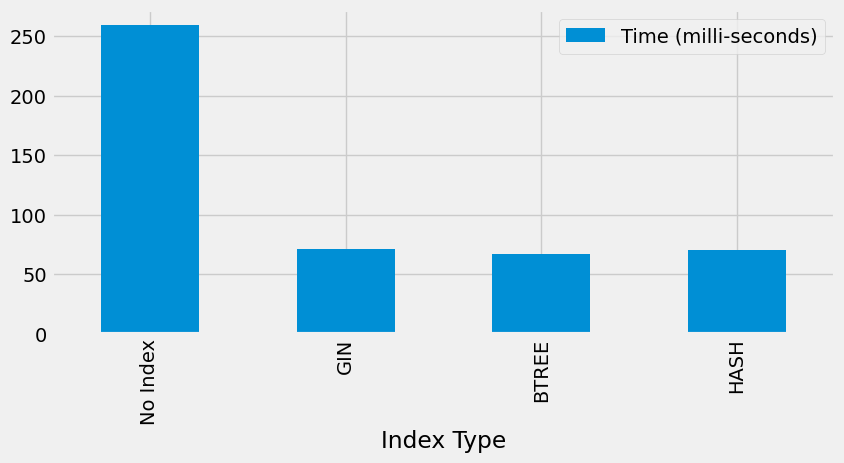

In [33]:
with plt.style.context("fivethirtyeight"):
    df.plot.bar(x="Index Type", y="Time (milli-seconds)", figsize=(9,4));
    plt.show();

## 11. 📊 Index Comparison Summary

| Index | Works On JSONB? | Good For | Pros | Cons |
|------|------------------|----------|------|-------|
| **GIN (default)** | ✔ Full JSONB | Key lookup, path search, containment (`@>`, `?`, `?\| `, `?&`) | Fastest, flexible | Biggest index size |
| **GIN (`jsonb_path_ops`)** | ✔ Full JSONB | Heavy use of @> contains queries on large JSONB documents | Fastest, flexible, Smaller Size than default GIN Index | Supports only `@>`. Not useful for `?`, `?\|` , or path queries |
| **BTREE** | ❌ only extracted fields | Equality filters | Very fast | Only one field |
| **HASH** | ❌ only extracted fields | Equality | Small index | Limited use |

---

### 🏆 Recommended
If you're working with JSONB,  
**GIN is the index you should almost always use.**

---

## 12. Conclusion

```markdown
JSONB makes PostgreSQL flexible and powerful —  
but without the right index, performance collapses quickly.

In this tutorial you learned:

- How slow JSONB queries are with no index  
- How GIN accelerates them by 5×–50×  
- When BTREE and HASH make sense  
- How to benchmark query performance like a pro  

Thanks for following along!
